# Bayesian Machine Learning
### By Rafał Karczewski

1. How does Bayesian Machine Learning differ from classical Machine Learning and why use it?
2. Bayesian Linear Regression
3. Markov Chain Monte Carlo
4. Variational Inference

## How does Bayesian Machine Learning differ from classical Machine Learning and why use it?

In all Machine Learning problems we are presented with a model/hypotesis and data. A model can be an assumption that data follows a linear model or a normal distribution. The problem is to find parameters of our model that are the most likely given the observed data $D$.

In Bayesian Machine Learning on the other hand we are interested in analysing the **distribution** of our model's parameters given the observed data $D$. In order to achieve that we always assume some distribution of our parameter $\theta$ _prior_ to observing any data. The problem is to find the _posterior_ distribution _after_ observing the data $$P\left(\theta|D\right)$$ We can retrieve that distribution using the Bayes' Theorem $$P\left(\theta|D\right)=\frac{P\left(D|\theta\right)P\left(\theta\right)}{P\left(D\right)}$$

Let's examine each part of that formula. First, the likelihood $$P\left(D|\theta\right)$$ This part is provided by our model/hypothesis. This indicates how likely it is that the data $D$ we observed follows our model with the parameter $\theta$.

Next, we have the prior distribution of our parameters $$P\left(\theta\right)$$ This part indicates how likely the parameter $\theta$ is the true value, prior to observing any data. This is sometimes called the expert knowledge assumption. Sometimes we choose this to be the [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) of the likelihood in order to enforce the posterior distribution to be _the same_ as the prior.

Finally, the _evidence_ term $$P\left(D\right)$$ This term indicates how likely was the data we observed. This is the most problematic part of the Bayesian Machine Learning, because we often cannot infer it. Since we know the likelihood and the prior, in theory we can compute the evidence using the sum-product rule $$P\left(D\right)=\int_{\theta}P\left(D|\theta\right)P\left(\theta\right)\mbox{d}\theta$$ but in practice this integral is often intractable.

Modeling the whole distribution of the parameter space as opposed to finding an optimal value of the parameters allows modeling of the uncertainties in the model, which in practice is crucial for useful inference from the model

OK, let's see how this works in practice

## Bayesian Linear Regression

Suppose our hypothesis is that the data follows a linear model $$Y=w_0+w_1X+\varepsilon$$ and we assume a simplified model where the variance of the noise is known and equal to $\beta^{-1}$ $$\varepsilon \sim \mathcal{N}\left(0, \beta^{-1}\right)$$ and consequently $$Y | X \sim \mathcal{N}\left(w_0 + w_1X,\beta^{-1}\right).$$

Since we do not have any prior knowledge, we will choose a prior for our parameters $w=\left(w_0,w_1\right)$ $$P\left(w\right)=\mathcal{N}\left(0, \alpha^2I\right)$$

There is also one more reason we chose the prior to be Gaussian. Since our model is Gaussian ($Y|X$) its conjugate prior is also Gaussian. This means that the posterior $P\left(w|D\right)$ will also be Gaussian and it enables us to find an analytic solution.

Let's first see what the prior looks like

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(2137)

from functools import reduce

In [2]:
n_gridpoints = 1000
x = np.linspace(-1., 1., n_gridpoints)
y = np.linspace(-1., 1., n_gridpoints)
W_0, W_1 = np.meshgrid(x, y)
W_1 = W_1[::-1]

In [3]:
alpha = 2.0

In [4]:
prior = np.exp(-alpha * (W_0**2 + W_1**2) / 2)
prior = prior / prior.sum()

In [5]:
def plot_distribution(p, ground_truth_bias=np.array([]), ground_truth_weight=np.array([])):
    plt.figure(figsize=(6, 6))
    plt.imshow(p, cmap='viridis')
    gt_bias = p.shape[0] * (ground_truth_bias + 1) / 2
    gt_weight = p.shape[1] * (1 - (ground_truth_weight + 1) / 2)
    plt.scatter(gt_bias, gt_weight, c='w', marker='+', s=p.shape[0] / 10)
    plt.xticks([0, p.shape[1] // 2, p.shape[1] - 1], [-1, 0, 1])
    plt.yticks([0, p.shape[0] // 2, p.shape[0] - 1], [1, 0, -1])
    plt.xlabel('bias', size=15)
    plt.ylabel('weight', size=15)
    plt.show()

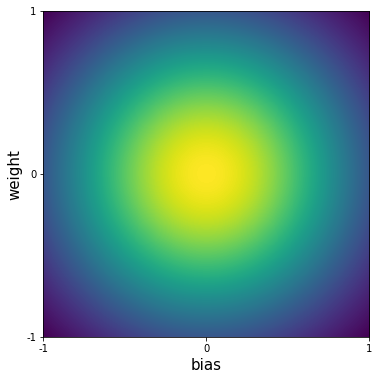

In [6]:
plot_distribution(prior)

And let's draw some samples from this distribution. Note that each sample of $w$ corresponds to a linear model, so we can plot them.

In [7]:
def sample_from_array(p, n):
    normalized_p = p / p.sum()
    n_outcomes = reduce(lambda x, y: x * y, p.shape)
    samples = np.random.choice(range(n_outcomes), size=n, p=normalized_p.flatten())
    x = samples // p.shape[0]
    y = samples % p.shape[1]
    return x, y

def sample_models_from_distribution(p, n, all_observed_x=[], all_observed_y=[]):
    x_coor, y_coor = sample_from_array(p, n)
    sampled_bias = W_0[x_coor, y_coor]
    sampled_weight = W_1[x_coor, y_coor]
    plt.figure(figsize=(7, 7))
    plt.scatter(all_observed_x, all_observed_y, s=100, marker='v')
    for bias, weight in zip(sampled_bias, sampled_weight):
        plt.plot(x, bias + weight * x, c='r')
    plt.xlim((-1.2, 1.2))
    plt.xlabel('x', size=15)
    plt.ylabel('y', size=15)
    plt.ylim((-1.2, 1.2))
    plt.show()

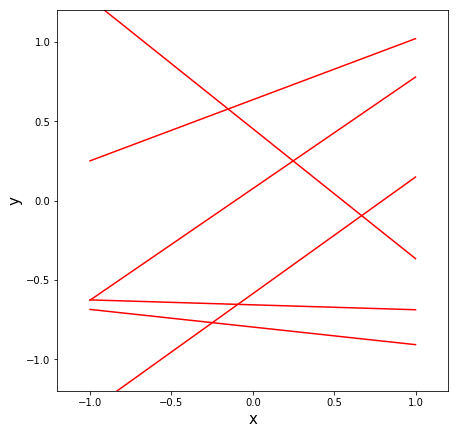

In [8]:
sample_models_from_distribution(prior, 6)

There is no evident pattern in the location and direction of these linear models, which is expected, since we've chosen a rather broad Gaussian prior, which means that large number of linear models are likely to be sampled.

Let's now generate some artificial data in to train our Bayesian model. The $x$ coordinate will be uniformly chosen from the $\left(-1, 1\right)$ and choose a corresponding $y$ as a linear transform of $x$ with additive Gaussian noise $$X \sim U\left(-1,1\right) \\ Y = -0.3 + 0.5 \cdot X + \varepsilon \\ \varepsilon \sim \mathcal{N}\left(0, \beta^{-1}\right)$$ This means that the ground truth values of our parameters is $w-\left(-0.3, 0.5\right)$.

Let's plot ground truth distribution

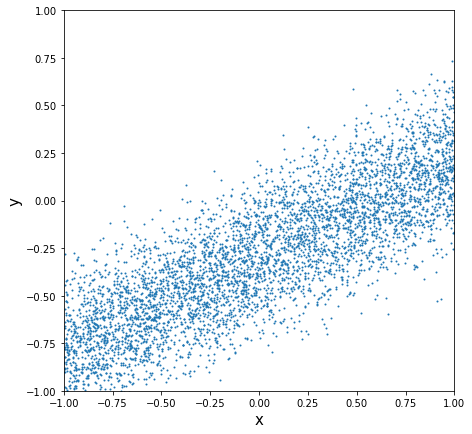

In [9]:
GROUND_TRUTH_BIAS = -0.3
GROUND_TRUTH_WEIGHT = 0.5
GROUND_TRUTH_NOISE = 25.

def sample_ground_truth(a_0, a_1, beta, n):
    x = np.random.uniform(-1, 1, n)
    y = a_0 + a_1 * x + np.random.normal(scale=np.sqrt(1 / beta), size=n)
    return x, y

x_gt, y_gt = sample_ground_truth(GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT, GROUND_TRUTH_NOISE, 5000)
plt.figure(figsize=(7, 7))
plt.scatter(x_gt, y_gt, s=1.)
plt.xlabel('x', size=15)
plt.ylabel('y', size=15)
plt.xlim((-1, 1))
_ = plt.ylim((-1, 1))

Let's sample one point from that distribution and its corresponding likelihood as a function of $w$.

In [10]:
first_observed_point = sample_ground_truth(GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT, GROUND_TRUTH_NOISE, 1)
first_x, first_y = first_observed_point
first_x, first_y = first_x[0], first_y[0]
all_observed_x = [first_x]
all_observed_y = [first_y]

In [11]:
def likelihood(x, y):
    return np.exp(-GROUND_TRUTH_NOISE * (y - W_0 - W_1 * x)**2 / 2)

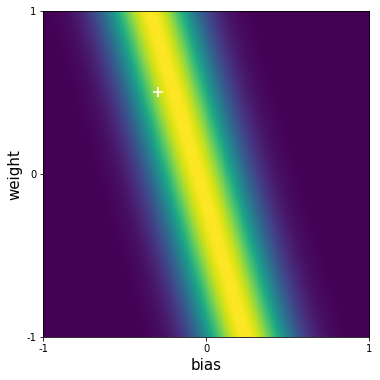

In [12]:
plot_distribution(likelihood(first_x, first_y), GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT)

On the plot we marked the ground gruth values of $w_0$ and $w_1$ with a white cross which has a high likelihood (good sign :)). Nonetheless it's not the only pair that has a high likelihood. In fact, every linear model that crosses the observed point $\left(x, y\right)$ has a high likelihood.

Now, let's look at the posterior

In [13]:
posterior = likelihood(first_x, first_y) * prior
posterior = posterior / posterior.sum()

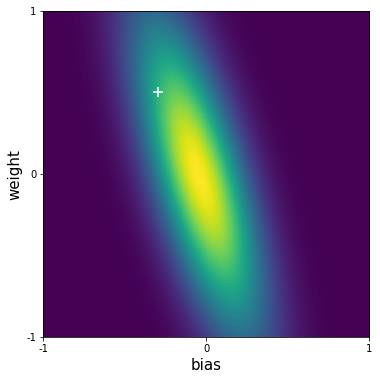

In [14]:
plot_distribution(posterior, GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT)

We see that the posterior is much narrower than the prior, which means that the model is much more certain. Also note that the ground truth has a high posterior probability. It is not in the middle of the posterior, because of the impact of the prior and the fact that the ground truth samples are not sampled exactly from the line, but with additional noise

Let's now sample models from that posterior distribution

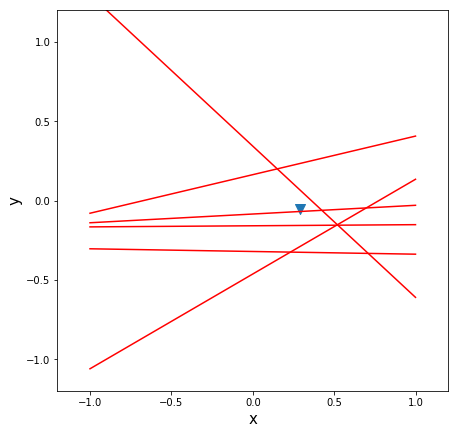

In [15]:
sample_models_from_distribution(posterior, 6, all_observed_x, all_observed_y)

We can see that the models sampled from the posterior distribution are more likely to cross the observed $\left(x, y\right)$ as opposed to the models sampled from the prior.

Let's see what happens after sampling one more point and treating our obtained posterior as a new prior

In [16]:
second_observed_point = sample_ground_truth(GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT, GROUND_TRUTH_NOISE, 1)
second_x, second_y = second_observed_point
second_x, second_y = second_x[0], second_y[0]
all_observed_x = [first_x, second_x]
all_observed_y = [first_y, second_y]

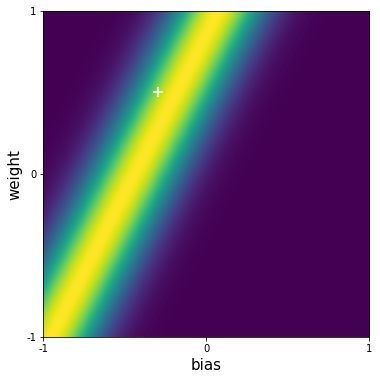

In [17]:
plot_distribution(likelihood(second_x, second_y), GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT)

In [18]:
posterior = likelihood(second_x, second_y) * posterior
posterior = posterior / posterior.sum()

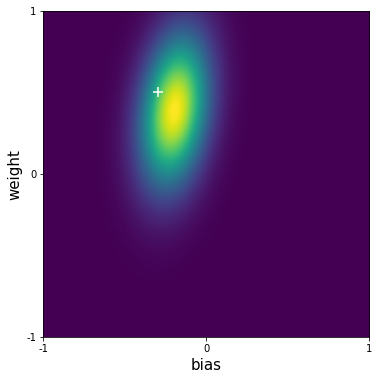

In [19]:
plot_distribution(posterior, GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT)

The posterior gets narrower

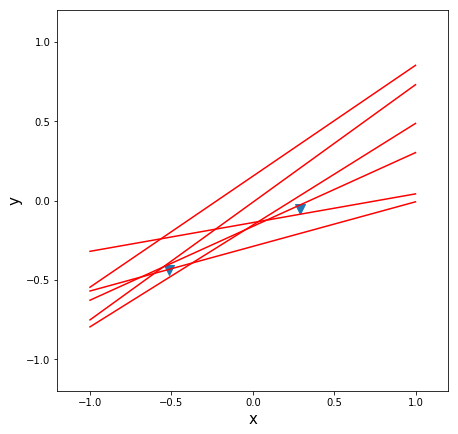

In [20]:
sample_models_from_distribution(posterior, 6, all_observed_x, all_observed_y)

And the corresponding sampled models have less variance

We will add another 28 points to obtain 30 total and in each iteration treat the latest posterior as a new prior

In [21]:
additional_points = sample_ground_truth(GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT, GROUND_TRUTH_NOISE, 28)
additional_x, additional_y = additional_points
all_observed_x = [first_x, second_x] + list(additional_x)
all_observed_y = [first_y, second_y] + list(additional_y)

In [22]:
for new_x, new_y in zip(additional_x, additional_y):
    posterior = likelihood(new_x, new_y) * posterior
    posterior /= posterior.sum()  # normalize

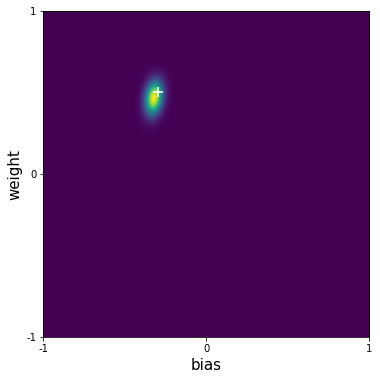

In [23]:
plot_distribution(posterior, GROUND_TRUTH_BIAS, GROUND_TRUTH_WEIGHT)

We see that the posterior is now very narrow and close to the ground truth

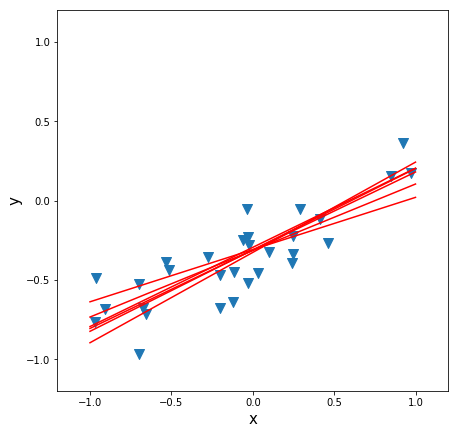

In [24]:
sample_models_from_distribution(posterior, 6, all_observed_x, all_observed_y)

Corresponding models have very little variance

We see that in the Bayesian approach we have a whole distribution of models which gets narrower and closer to the ground truth with each observed data point. However, in practical applications we are not always interested in the distribution of $w$, but rather in the distribution $y | w, x$ often called the _predictive distribution_. Since the prior on the weights and the noise we Gaussian, the predictive distribution is also Gaussian $$Y|w, x \sim \mathcal{N}\left(m\left(x\right), \sigma^2\left(x\right)\right).$$ Note that the mean **and the variance** of that distribution depend on the input $x$.

## Predictive distribution

In [25]:
def predictive_distribution(all_observed_x, all_observed_y):
    theta = np.column_stack([np.ones(len(all_observed_x)), all_observed_x])
    covariance_inverse = alpha * np.eye(2) + GROUND_TRUTH_NOISE * np.dot(theta.T, theta)
    covariance = np.linalg.inv(covariance_inverse)
    mean = GROUND_TRUTH_NOISE * np.dot(covariance, np.dot(theta.T, np.array(all_observed_y)))
    return mean, covariance

In [26]:
def point_wise_distribution(x_new, predictive_mean, predictive_covariance):
    theta = np.array([1, x_new])
    mean = np.dot(predictive_mean, theta)
    variance = 1 / GROUND_TRUTH_NOISE + np.dot(theta, np.dot(predictive_covariance, theta))
    return mean, variance

In [27]:
def plot_predictive_distribution(all_observed_x, all_observed_y):
    predictive_mean, predictive_covariance = predictive_distribution(all_observed_x, all_observed_y)
    x = np.linspace(-5, 5, n_gridpoints)
    mean, variance = zip(*[point_wise_distribution(x_new, predictive_mean, predictive_covariance) for x_new in x])
    plt.figure(figsize=(7, 7))
    plt.scatter(all_observed_x, all_observed_y, s=100, marker='v')
    plt.plot(x, mean, c='r')
    plt.fill_between(
        x, mean + np.sqrt(variance), mean - np.sqrt(variance),
        color='r', alpha=.25)
    plt.xlim((-5.2, 5.2))
    plt.ylim((-2.2, 2.2))
    plt.xlabel('x', size=15)
    plt.ylabel('y', size=15)

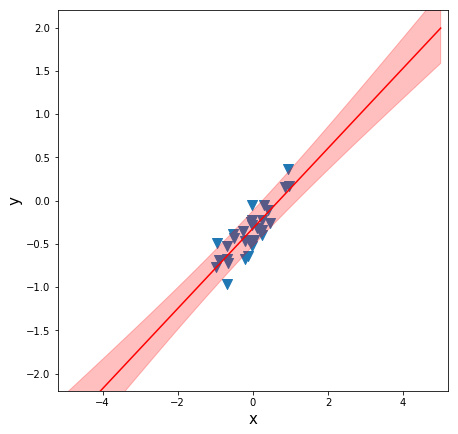

In [28]:
n_data_points = 30  # change this value to see how the predictive distibution changes
plot_predictive_distribution(all_observed_x[:n_data_points], all_observed_y[:n_data_points])

We see that the predictive uncertainty (variance) gets smaller with more observed data and in general is smaller near the observed data points.

## Markov Chain Monte Carlo

The Bayesian linear regression is an example where the posterior distribution is Gaussian. In particular we know its mean, covariance and know how to efficiently sample from it. However, in most applications the posterior won't be Gaussian and often it may be without an analytic form. The _Markov Chain Monte Carlo_ algorithms is a family of solutions that enable sampling from any posterior.

The idea behind MCMC is to **construct a reversible Markov Chain in such a way that its equilibrium distribution is the posterior we want to sample from**.

OK, it sounds complicated. Let's break it down.

_Construct a reversible **Markov Chain** in such a way that its equilibrium distribution is the posterior we want to sample from_. A Markov Chain is a stochastic process satisfying the following $$P\left(X_{t+1}|X_1, X_2, \dots, X_t\right)=P\left(X_{t+1}|X_t\right).$$ In other words, the distribution of the process at a particular time step, _given that we know all the history depends only on the previous time step_. For example, a random walk: $$X_{t+1}=X_{t}+\varepsilon_{t+1}.$$ We often denote the transition probability $$P_{t \to t+1}\left(x, x'\right)=P\left(X_{t+1}=x|X_t=x'\right)$$

_Construct a reversible Markov Chain in such a way that its **equilibrium distribution** is the posterior we want to sample from_. The equilibrium distribution of a Markov Chain is any distribution $\pi$ satisfying the following $$\pi\left(x\right)=\int_{x'}P_{t\to t+1}\left(x, x'\right)\pi \left(x'\right)\mbox{d}x'.$$ In other words if $X_t$ follows the distribution $\pi$ then $X_{t+1}$ also follows $\pi$ $$X_t \sim \pi \implies X_{t+1} \sim \pi.$$

_Construct a **reversible** Markov Chain in such a way that its equilibrium distribution is the posterior we want to sample from_. a reversible Markov Chain is a Markov Chain satisfying $$P\left(X_t\right) \xrightarrow[t \to \infty]{} \pi.$$ This means that, _regardless of where we start_, the distribution of subsequent time steps will converge to the stationary distribution.

To sum up, if we can _construct a reversible Markov Chain in such a way that its equilibrium distribution is the posterior we want to sample from_ we are guaranteed that the samples from that Markov Chain (regardless of the starting point) will follow that distribution _long enough_ sampling.

OK, how does it translate to the Bayesian framework?

The most popular is the Metropolis-Hastings sampling algorithm, which construct a Markov Chain in a following way. Suppose we have a parameter $\theta$, its prior $P\left(\theta\right)$ and a model $P\left(D|\theta\right)$. We are interested in sampling from the posterior $$P\left(\theta|D\right)=\frac{P\left(D|\theta\right)P\left(\theta\right)}{P\left(D\right)}.$$

We initialize randomly with $\theta_0$. At each time step we generate a _candidate_ $$c_{t+1}=\theta_t+\varepsilon,$$ where $\varepsilon \sim \mathcal{N}\left(0, \lambda^2I\right)$ (the $\lambda$ parameter is the _proposal width_ and will be discussed later). Is it a better candidate that our current value $\theta_t$? We look whether it was more likely given the observed data $$a=\frac{P\left(c_{t+1} |D\right)}{P\left(\theta_t|D\right)}=\frac{\frac{P\left(D|c_{t+1}\right)P\left(c_{t+1}\right)}{P\left(D\right)}}{\frac{P\left(D|\theta_t\right)P\left(\theta_t\right)}{P\left(D\right)}}=\frac{P\left(D|c_{t+1}\right)P\left(c_{t+1}\right)}{P\left(D|\theta_t\right)P\left(\theta_t\right)}.$$ Note that the problematic evidence term $P\left(D\right)$ gets cancelled out. We define the acceptance probability $$p_{\mbox{accept}}=\min\lbrace a, 1\rbrace$$ and define $\theta_{t+1}$ to be either $c_{t+1}$ or remain $\theta_t$ with that probability $$\theta_{t+1}=\begin{cases}c_{t+1} & \mbox{ with probability }p_{\mbox{accept}} \\ \theta_t & \mbox{ with probability }1 - p_{\mbox{accept}}. \end{cases}$$ This means that if our candidate is more likely given the observed data, we take it. If it is not, we can still take with some probablity depending or how likely it is relative to our current estimate. This helps us escape the local minima.

It can be shown that the Markov process defined in the Metropolis Hastings algorithm is reversible and its stationary distribution is $P\left(\theta|D\right)$. This means that samples from that Markov Chain after a _long time_ will follow the desired posterior no matter where we initialized $\theta$.

OK, that's theory. What about practice?

Consider a problem of modelling a normal distibution. We will assume that the data comes from a normal distribution with unknown mean parameter $\mu$ and a known variance $\sigma^2=1$ $$X \sim \mathcal{N}\left(\mu, 1\right).$$ Pior to observing any data, we assume that $\mu$ is normally distributed $$\mu \sim \mathcal{N}\left(0, 1\right).$$

We will now draw some ground truth samples (ground truth $\mu=0$) $$X \sim \mathcal{N}\left(0, 1\right).$$

In [29]:
import scipy as sp
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [30]:
data = np.random.randn(20)

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


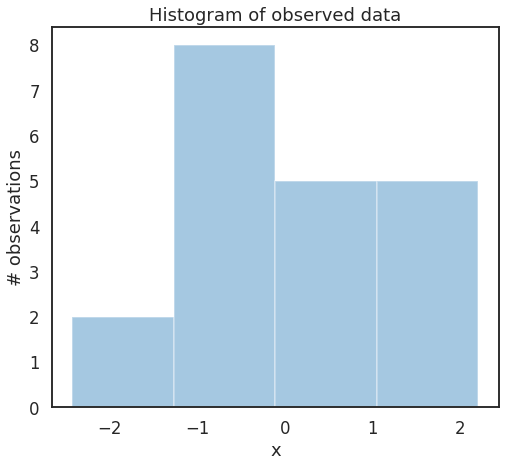

In [31]:
plt.figure(figsize=(8, 7))
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Again, as in the case of Bayesian linear regression, we chose a normal prior, which means that the actual posterior is Gaussian and we can compute it analytically

In [32]:
def posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

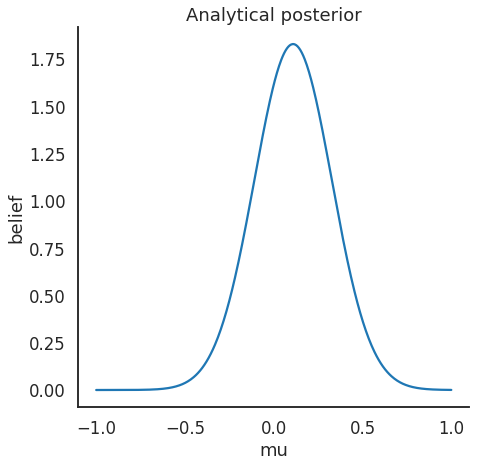

In [33]:
plt.figure(figsize=(7, 7))
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior = posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

Let's now generate 15000 samples according to the MCMC algorithm starting with $\mu_0=\frac{1}{2}$ and the proposal width $\lambda=\frac{1}{2}$.

In [34]:
def sampler(data, n_samples=4, mu_init=.5, proposal_width=.5, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    samples = [mu_current]
    for i in range(n_samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        p_accept = p_proposal / p_current
        
        accept = np.random.rand() < p_accept

        if accept:
            mu_current = mu_proposal
        
        samples.append(mu_current)
        
    return samples

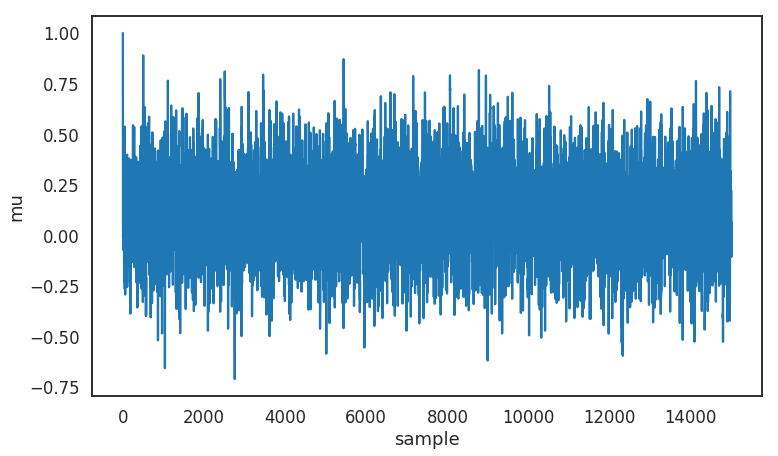

In [35]:
samples = sampler(data, n_samples=15000, mu_init=1.)
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(samples)
_ = ax.set(xlabel='sample', ylabel='mu');

This is called a trace plot, which shows a trajectory of the Markov Chain. Let's analize the estimated posterior by computing the histogram of the generated samples.

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


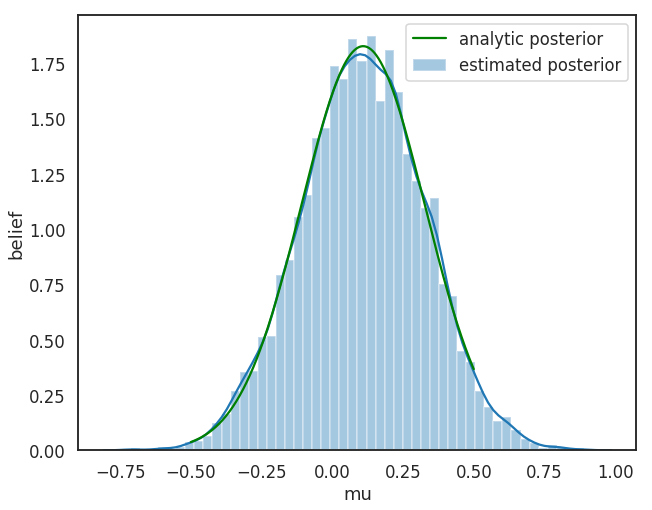

In [36]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.distplot(samples[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

We see that the samples approximate the analytical posterior almost perfectly what aligns with the theory. We chose the proposal width $\lambda=\frac{1}{2}$ somewhat randomly. Let's see what happens if we choose it to be very small $\lambda=\frac{1}{100}$.

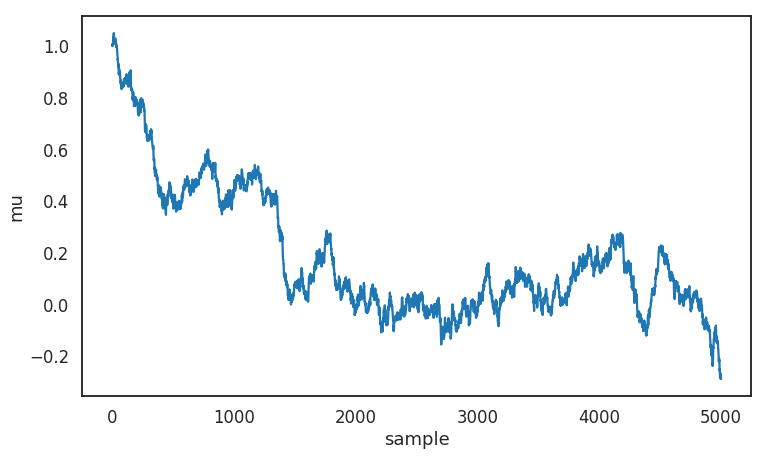

In [37]:
samples_small_width = sampler(data, n_samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(samples_small_width);
_ = ax.set(xlabel='sample', ylabel='mu');

or very large $\lambda=3$

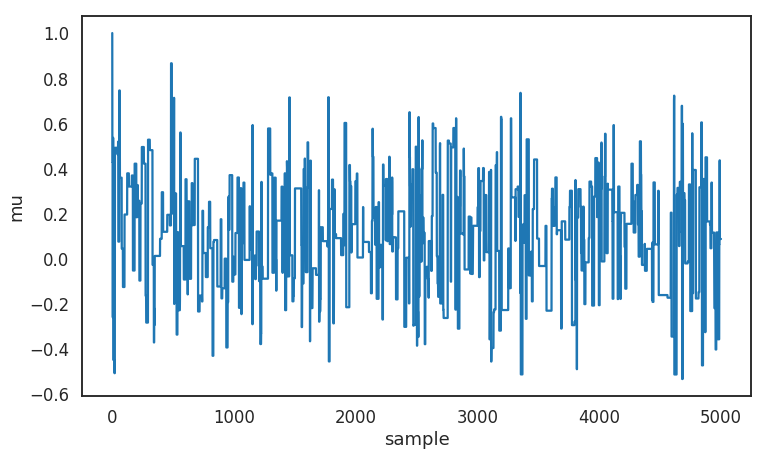

In [38]:
samples_large_width = sampler(data, n_samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(samples_large_width); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

We see that the _randomness_ is somewhat lost in these samples. It is because for a small proposal width the steps are to small and subsequent samples are very close to each other and there is a lot of autocorrelation. In the case of a large proposal width the jumps are to large, so once the process lands in the high likelihood area it is difficult to esape and it remains constant.

Nonetheless, the Markov Chain theory _guarantees_ convergence regardless of the starting point **and the proposal width**. Let's see how these samples approximate our posterior

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


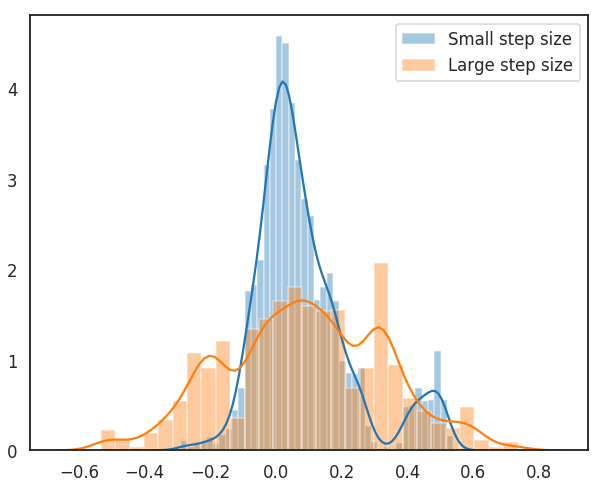

In [39]:
plt.figure(figsize=(10, 8))
ax.plot(x, post, 'g', label='analytic posterior')
sns.distplot(samples_small_width[1000:], label='Small step size')
sns.distplot(samples_large_width[1000:], label='Large step size');
_ = plt.legend();

We see that they approximate the true posterior, but significantly worse than the medium proposal width. It means that for too small and too large proposal widths the algorithm would need a lot more samples to converge. 

Apart from convergence to the correct distribution we are interested in the correlation between samples. Ideally, we would like the samples to be independent, but that's not possible since the algorithm samples from the Markov Chain. We aim to get as small autocorrelation as possible. Let's see what it looks like for different values of proposal width.

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


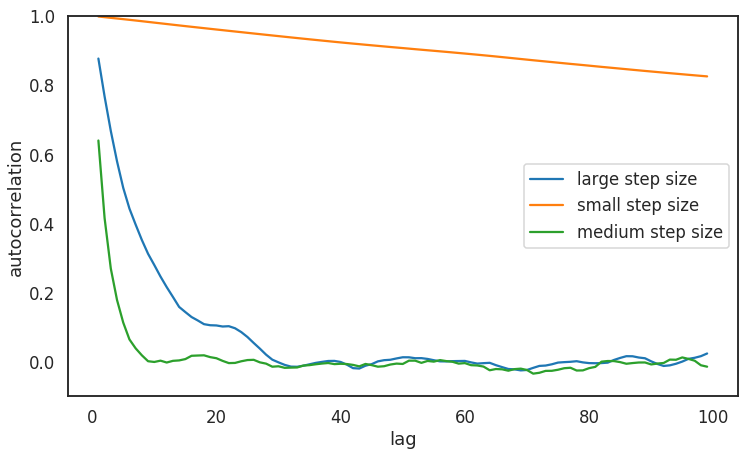

In [40]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(lags, [autocorr(np.array(samples_large_width), l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(np.array(samples_small_width), l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(np.array(samples), l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

It turns out that the algorithm has the least autocorrelation for the medium proposal width, so appart from quicker convergence, we can obtain better estimates of the mean of our posterior.

There is a plug-and-play implementation in the pyMC3 package, which performs the MCMC in parallel and automatically finds an appropriate proposal width for a given task

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains: 100%|██████████| 62000/62000 [00:06<00:00, 9144.18draws/s] 
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


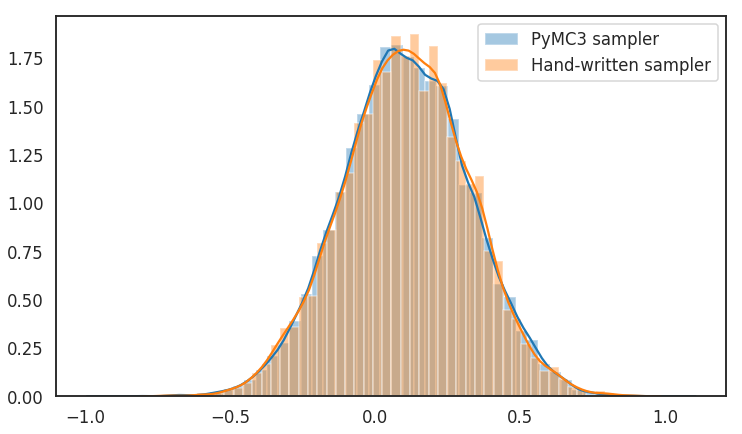

In [41]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)

plt.figure(figsize=(12, 7))
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(samples[500:], label='Hand-written sampler');
plt.legend();

## Variational inference

There are several problems with MCMC algorithms
1. It is difficult to assess convergence
2. Depends on the choice of the proposal width

Alternative? _Variational Inference_

The idea behind variational inference is similar to MCMC, but instead of a sampling algorithm, we want to find a tractable, closed-form distribution which approximates the true posterior. This is achieved by proposing a variational analytic distribution $Q$, which minimizes the distance from the true posterior.

OK, but how to measure distance between probability distributions? The most common approach is to use the _Kullback Leibler divergence_ $$D_{KL}\left(Q || P\right)=\int_xQ\left(x\right)\log\left(\frac{Q\left(x\right)}{P\left(x\right)}\right)\mbox{d}x$$

In the Bayesian framework we will be interested in approximating the posterior probability $p\left(\theta|D\right)$ with some distribution $q\left(\theta;w\right)$ governed by some parameters $w$. We are therefore interested in minimizing the $KL$ divergence with respect to the variational distribution's parameters $$\min_w \left(D_{KL}\left(q\left(\theta;w\right)||p\left(\theta|D\right)\right)\right)$$

Since the problem may be high dimensional, we want to use an efficient optimization algorithm such as Gradient Descent, but how to efficiently compute the gradient of the $KL$ divergence since the posterior $p\left(\theta|D\right)$ is intractable?

Notice that the divergence can be rewritten as follows $$D_{KL}\left(Q||P\right)=\log P\left(D\right) - L\left(Q\right)$$ where $$L\left(Q\right)=\int_\theta \log \left(\frac{P\left(\theta, D\right)}{Q\left(\theta\right)}\right) Q\left(\theta\right)\mbox{d}\theta$$

One can see that $\log P\left(D\right) = L\left(Q\right) + D_{KL}\left(Q||P\right)$ and since the $KL$ divergence is non negative we obtain $$\log P\left(D\right) \ge L\left(Q\right)$$ which is why $L\left(Q\right)$ is called the _Evidence Lower Bound_ (ELBO)

Since $\log P\left(D\right)$ does not depend on $Q$ the minimization of the $KL$ divergence is equivalent to maximizing the ELBO

It can be further shown that the ELBO satifies $$L\left(Q\right)=\int_{\theta}\log P\left(\theta, D\right) Q\left(\theta\right)\mbox{d}\theta - \int_{\theta}Q\left(\theta\right)\log Q\left(\theta\right)\mbox{d}\theta=\mathbb{E}_{\theta \sim Q}\log P\left(\theta, D\right) + H\left(Q\right)$$ where $H$ is the entropy. This decomposition really neatly illustrates the trade-off that the Variational Inference is trying to solve.
1. Maximization of the first term results in an atomic distribution at the maximum of $\log P\left(\theta, D\right)$, which results in zero entropy
2. Maximization of entropy results in a uniform distribution, which results in suboptimal solution of the first term.

_The maximization of ELBO tries to maximize the probability mass for the most values of $\theta$ and $D$ while simultaneously assuring a wide distribution_.

We are interested in the gradient of $L$ with respect to $w$. Since we choose $Q$ to be tractable, the entropy term is often analytic and easily differentiable. The problematic part is $$\nabla_w \mathbb{E}_{\theta \sim Q}\log P\left(\theta, D\right),$$ because the distribution we sample from is also dependent on $w$.

This is solved by the _reparametrization trick_. Suppose you want to find $$\nabla_w \mathbb{E}_{x \sim X}f\left(x\right)$$ where $X \sim \mathcal{N}\left(\mu, \sigma^2\right)$ One can see that $X$ can be reparametrized in the following way $$X \sim \mu + \sigma Z$$ where $Z \sim \mathcal{N}\left(0, 1\right)$. Then we see that our optimization problem simplifies to $$\nabla_w \mathbb{E}_{x \sim X}f\left(x\right)=\nabla_w \mathbb{E}_{z \sim Z}f\left(\mu + \sigma z\right)=\mathbb{E}_{z \sim Z}\nabla_w f\left(\mu + \sigma z\right)$$ which means that the gradient can be expressed as an expectation of a tractable distribution!

In our problem we often choose variational distributions $Q$ that can be reparametrized in such manner, which means that the problem of estimation the gradient of ELBO comes down to $$\nabla_w \mathbb{E}_{\theta \sim Q}\log P\left(\theta, D\right)=\nabla_w \mathbb{E}_{z \sim Z}\log P\left(\theta\left(z\right), D\right)=\mathbb{E}_{z \sim Z}\nabla_w\log P\left(\theta\left(z\right), D\right)$$ where the joint distribution $P\left(\theta\left(z\right), D\right)$ can be factorized into likelihood and the prior which are both tractable $$P\left(\theta\left(z\right), D\right)=P\left(D|\theta\left(z\right)\right)P\left(\theta\left(z\right)\right)$$ which makes it possible to approximate it by sampling $$\nabla_w \mathbb{E}_{\theta \sim Q}\log P\left(\theta, D\right) \approx \frac{1}{N}\sum_{i=1}^N\nabla_w \log \left(P\left(D|\theta\left(z_i\right)\right)P\left(\theta\left(z_i\right)\right)\right)$$ where $z_i$ are drawn from the tractable reparametrized variational distribution

OK, to sum up:
1. We want to approximate the true posterior $P\left(\theta|D\right)$ with an analytic distribution (e.g. Gaussian)
2. We choose the parametrized variational distribution $Q$ and want to find parameters that minimize the $KL$ divergence
3. The $KL$ divergence depends on the true posterior, which means that we cannot find its derivates for efficient optimization
4. It turns out that minimization of $KL$ divergence is equivalent to maximization of ELBO, which can be decomposed to an analytic entropy term and an expectation with respect to $Q$ (we know how to sample from Q!)
5. With the reparametrization trick we know how to efficiently estimate the gradient of ELBO and find its maximum using gradient ascent

And finally, some practice

Suppose we want to model a mixture of 3 Gaussian distributions. Our prior assumptions are $$\mu_1,\mu_2, \mu_3 \sim \mathcal{N}\left(0, \sigma^2\right) \\ \tau_1, \tau_2, \tau_3 \sim \Gamma\left(a, b\right) \\ w \sim \mbox{Dir}\left(\alpha\right) \\ f\left(x|w\right)=\sum_{i=1}^3w_iN\left(x;\mu_i, \tau_i^{-1}\right)
$$

We generate the ground truth data

In [42]:
SEED = 383561
np.random.seed(SEED)

N = 2000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])

In [43]:
component = np.random.choice(MU.size, size=N, p=W)
x = np.random.normal(MU[component], SIGMA[component], size=N)

/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


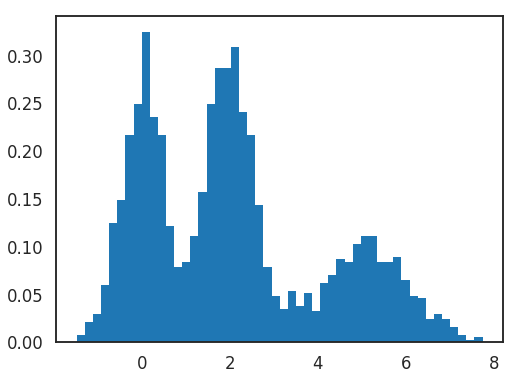

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(x, bins=50, normed=True, lw=0);

We define the model in PyMC3

In [45]:
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones_like(W))

    mu = pm.Normal('mu', 0., 10., shape=W.size)
    tau = pm.Gamma('tau', 1., 1., shape=W.size)

    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=x)

In [46]:
with model:
    advi_fit = pm.fit(n=30000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 3,842.8: 100%|██████████| 30000/30000 [00:30<00:00, 996.53it/s]
Finished [100%]: Average Loss = 3,842.8


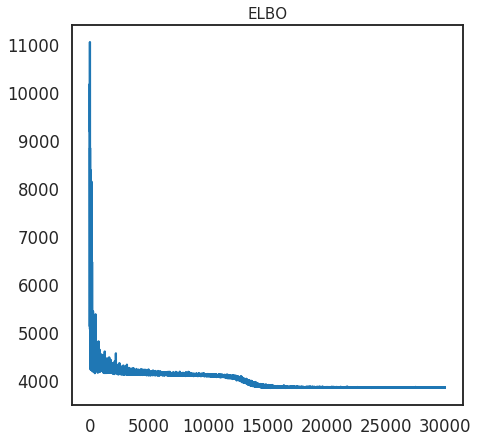

In [47]:
plt.figure(figsize=(7, 7))
plt.title('ELBO', size=15)
plt.plot(advi_fit.hist)

We see that the ELBO converges to some minimum and stabilizees

Now let's draw some samples from the posterior distribution

In [48]:
trace = advi_fit.sample(5000)[1000:]

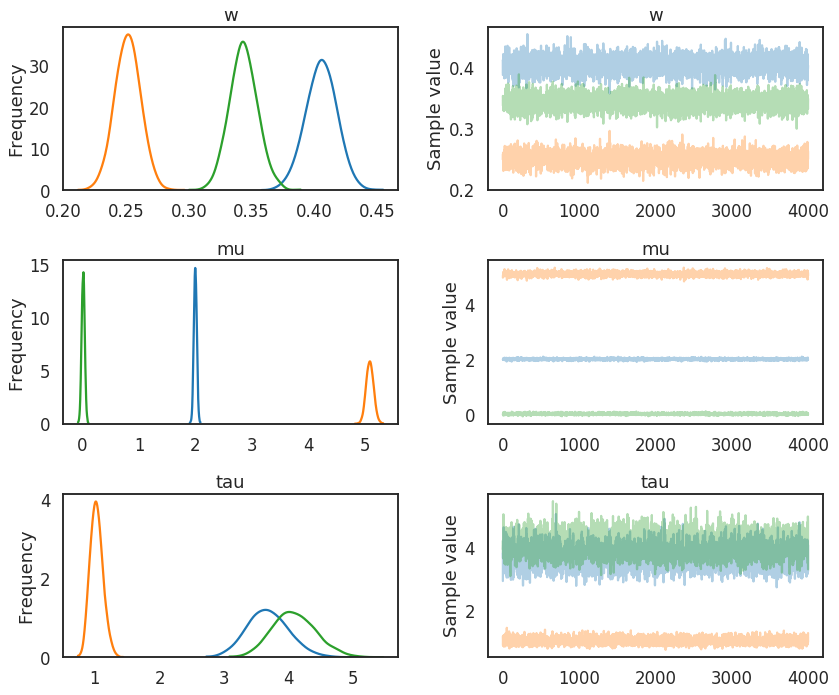

In [49]:
pm.traceplot(trace, varnames=['w', 'mu', 'tau'], figsize=(12,10));

And the predictive posterior distribution

In [61]:
with model:
    ppc_trace = pm.sample_ppc(trace, samples=5000, random_seed=SEED)

100%|██████████| 5000/5000 [00:08<00:00, 595.21it/s]


/usr/local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


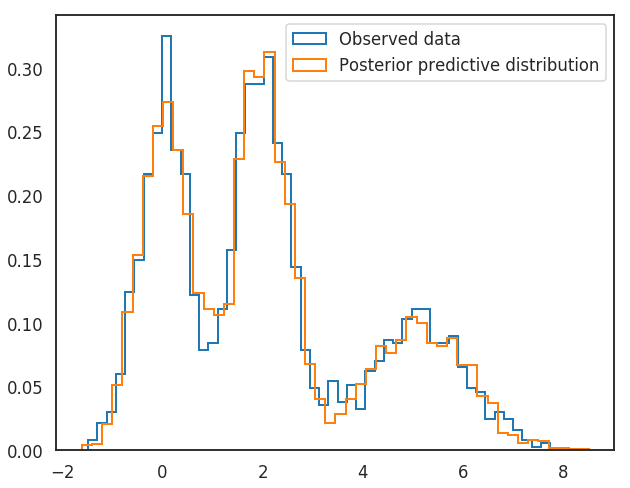

In [51]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.hist(x, bins=50, normed=True,
        histtype='step', lw=2,
        label='Observed data');
ax.hist(ppc_trace['x_obs'][:,0], bins=50, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

ax.legend(loc=1);

## References

1. [Bayesian linear regression example by Bishop et al.](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf)
2. [MCMC example by Thomas Wiecki](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/)
3. [Plotly example notebooks](https://plot.ly/ipython-notebooks/computational-bayesian-analysis/)
4. [Variational Inference theory](http://www.orchid.ac.uk/eprints/40/1/fox_vbtut.pdf)
5. [Zhiya Zuo's blog post on Variational Inference](https://zhiyzuo.github.io/VI/)
6. [Gaussian Mixture example from PyMC3](https://docs.pymc.io/notebooks/marginalized_gaussian_mixture_model.html)